# Введение в глубинное обучение, ФКН ВШЭ

## Домашнее задание 3. Обработка текстов.

### Общая информация

Дата выдачи: 13.01.2022

Мягкий дедлайн: 23:59MSK 6.02.2022

Жесткий дедлайн: 23:59MSK 10.02.2022

Оценка после штрафа после мягкого дедлайна вычисляется по формуле $M_{penalty} = M_{full} \cdot 0.85^{t/1440}$, где $M_{full}$ — полная оценка за работу без учета штрафа, а $t$ — время в минутах, прошедшее после мягкого дедлайна (округление до двух цифр после запятой). Таким образом, спустя первые сутки после мягкого дедлайна вы не можете получить оценку выше 8.5, а если сдать перед самым жестким дедлайном, то ваш максимум — 5.22 балла.

### Оценивание и штрафы

Максимально допустимая оценка за работу — 10 баллов. Сдавать задание после указанного срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В данном домашнем задании вам предстоит предсказывать пользовательскую оценку отеля по тексту отзыва. Нужно обучиться на данных с кэггла и заслать в [соревнование](https://www.kaggle.com/t/3e8fa6cec6d048bf8e93fb72e441d88c) предикт. По той же ссылке можете скачать данные.

Мы собрали для вас отзывы по 1500 отелям из совершенно разных уголков мира. Что это за отели - секрет. Вам дан текст отзыва и пользовательская оценка отеля. Ваша задача - научиться предсказывать оценку отеля по отзыву.

Главная метрика - Mean Absolute Error (MAE). Во всех частях домашней работы вам нужно получить значение MAE не превышающее 0.92 на публичном лидерборде. В противном случае мы будем вынуждены не засчитать задание :( 

#### Про данные:
Каждое ревью состоит из двух текстов: positive и negative - плюсы и минусы отеля. В столбце score находится оценка пользователя - вещественное число 0 до 10. Вам нужно извлечь признаки из этих текстов и предсказать по ним оценку.

Для локального тестирования используйте предоставленное разбиение на трейн и тест.

Good luck & have fun! 💪

#### Использовать любые данные для обучения кроме предоставленных организаторами строго запрещено. В последней части можно использовать предобученные модели из библиотеки `transformers`.

In [ ]:
from simpletransformers.classification import ClassificationModel
import pandas as pd
import numpy as np


from gensim.models import fasttext
import string
from nltk.tokenize import word_tokenize

import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack


from PIL import Image
from tqdm.notebook import tqdm


from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

from sklearn.linear_model import Ridge, LogisticRegression

from gensim.models import Word2Vec
import warnings 

from torch.nn.utils.rnn import pad_sequence
warnings.filterwarnings('ignore')

In [1]:
PATH_TO_TRAIN_DATA = 'data/train.csv'

In [2]:
df = pd.read_csv(PATH_TO_TRAIN_DATA)
df.head()

,review_id,negative,positive,score
0,00003c6036f30f590c0ac435efb8739b,There were issues with the wifi connection,No Positive,7.1
1,00004d18f186bf2489590dc415876f73,TV not working,No Positive,7.5
2,0000cf900cbb8667fad33a717e9b1cf4,More pillows,Beautiful room Great location Lovely staff,10.0
3,0000df16edf19e7ad9dd8c5cd6f6925e,Very business,Location,5.4
4,00025e1aa3ac32edb496db49e76bbd00,Rooms could do with a bit of a refurbishment ...,Nice breakfast handy for Victoria train stati...,6.7


In [3]:
df['summary'] = df['positive'] + ' ' + df['negative']

Предобработка текста может сказываться на качестве вашей модели.
Сделаем небольшой препроцессинг текстов: удалим знаки препинания, приведем все слова к нижнему регистру. 
Однако можно не ограничиваться этим набором преобразований. Подумайте, что еще можно сделать с текстами, чтобы помочь будущим моделям? Добавьте преобразования, которые могли бы помочь по вашему мнению.

Также мы добавили разбиение текстов на токены. Теперь каждая строка-ревью стала массивом токенов.

In [4]:
# import nltk
# nltk.download('punkt')

In [5]:
def process_text(text):
    text = [word for word in word_tokenize(text.lower()) if word not in string.punctuation]
    return ' '.join(text)

In [6]:
tqdm.pandas()
df['negative'] = df['negative'].progress_apply(process_text)
df['positive'] = df['positive'].progress_apply(process_text)
df['summary'] = df['summary'].progress_apply(process_text)

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

### Часть 1. 1 балл

Обучите логистическую или линейную регрессию на TF-IDF векторах текстов.

In [7]:
tfidf = TfidfVectorizer()
X_positive = tfidf.fit_transform(df['positive'])
X_negative = tfidf.fit_transform(df['negative'])
X_summary = tfidf.fit_transform(df['summary'])

X = hstack((X_positive, X_negative, X_summary))


In [8]:
X_positive.shape, X_negative.shape, X_summary.shape, X.shape

((100000, 21757), (100000, 24477), (100000, 34692), (100000, 80926))

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, df['score'], random_state=1412) # <- для локального тестирования


In [11]:
model = Ridge()
model.fit(X_train, y_train)
pred = model.predict(X_test)
print('MAE: %.4f' % mean_absolute_error(y_test, pred))

MAE: 0.8234


Предскажите этой моделью тестовые данные из [соревнования](https://www.kaggle.com/t/3e8fa6cec6d048bf8e93fb72e441d88c) и сделайте сабмит. Какой у вас получился скор? Прикрепите скриншот из кэггла.

In [12]:
test = pd.read_csv('data/test.csv')
test.head()

,review_id,negative,positive
0,00026f564b258ad5159aab07c357c4ca,Other than the location everything else was h...,Just the location
1,000278c73da08f4fcb857fcfe4ac6417,No UK TV but this was a minor point as we wer...,Great location very comfortable clean breakfa...
2,000404f843e756fe3b2a477dbefa5bd4,A tiny noisy room VERY deceptively photographed,The breakfast booked the preceding night but ...
3,000a66d32bcf305148d789ac156dd512,Noisy various electrical devices kicking in r...,Great location Nice bathroom
4,000bf1d8c5110701f459ffbedbf0d546,No Negative,Great location and friendly staff


In [13]:
test['summary'] = test['positive'] + ' ' + test['negative']

In [14]:
test['negative'] = test['negative'].progress_apply(process_text)
test['positive'] = test['positive'].progress_apply(process_text)
test['summary'] = test['summary'].progress_apply(process_text)

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

tfidf = TfidfVectorizer()
X_positive = tfidf.fit_transform(df['positive'])
X_positive_test = tfidf.transform(test['positive'])

X_negative = tfidf.fit_transform(df['negative'])
X_negative_test = tfidf.transform(test['negative'])

X_summary = tfidf.fit_transform(df['summary'])
X_summary_test = tfidf.transform(test['summary'])

X_train = hstack((X_positive, X_negative, X_summary))
y_train = df['score']

X_test = hstack((X_positive_test, X_negative_test, X_summary_test))


In [17]:
X_positive.shape, X_positive_test.shape, y_train.shape

((100000, 21757), (20000, 21757), (100000,))

In [18]:
model = Ridge()
model.fit(X_train, y_train)
pred = model.predict(X_test)

In [19]:
pd.DataFrame({'review_id': test['review_id'], 'score': pred}).to_csv('ans.csv', index=False)

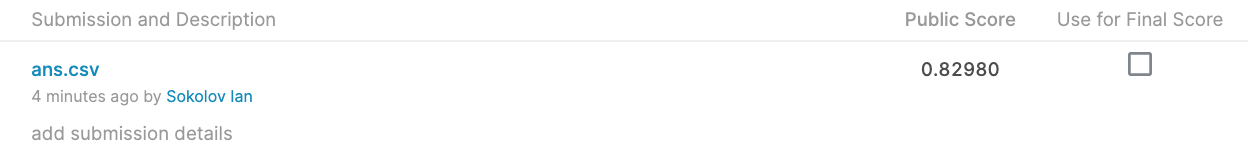

In [20]:
Image.open('task1.png')

### Часть 2. 2 балла

Обучите логистическую или линейную регрессию на усредненных Word2Vec векторах. 

In [21]:
df['negative_splitted'] = df['negative'].apply(lambda x: x.split())
df['positive_splitted'] = df['positive'].apply(lambda x: x.split())
df['summary_splitted'] = df['summary'].apply(lambda x: x.split())

In [22]:
model_positive = Word2Vec(df['positive_splitted'], sg=1, epochs=10, vector_size=300, min_count=0)
model_negative = Word2Vec(df['negative_splitted'], sg=1, epochs=10, vector_size=300, min_count=0)
model_summary = Word2Vec(df['summary_splitted'], sg=1, epochs=10, vector_size=300, min_count=0)


In [23]:
model_positive.wv.unit_normalize_all()
model_negative.wv.unit_normalize_all()
model_summary.wv.unit_normalize_all()

In [24]:
## SPLITTING

df_train, df_test = train_test_split(df, random_state=1412) # <- для локального тестирования

In [43]:
def vector_process(model, s, frequency = None):
    vec = np.array([model.wv[word] for word in s if word in model.wv])
    if vec.shape == (0, ):
        return np.zeros((1, model.vector_size))
    if frequency != None:
        w = np.array([frequency[word] for word in s if word in frequency])
        vec *= w.reshape(vec.shape[0], -1)
        return (np.sum(vec, axis = 0) / vec.shape[0]).reshape(1, -1)
    else:
        return np.mean(vec, axis = 0).reshape(1, -1)

train_vec_positive = np.concatenate(df_train['positive_splitted'].progress_apply(lambda x : vector_process(model_positive, x)).values)
train_vec_negative = np.concatenate(df_train['negative_splitted'].progress_apply(lambda x : vector_process(model_negative, x)).values)
train_vec_summary = np.concatenate(df_train['summary_splitted'].progress_apply(lambda x : vector_process(model_summary, x)).values)

test_vec_positive = np.concatenate(df_test['positive_splitted'].progress_apply(lambda x : vector_process(model_positive, x)).values)
test_vec_negative = np.concatenate(df_test['negative_splitted'].progress_apply(lambda x : vector_process(model_negative, x)).values)
test_vec_summary = np.concatenate(df_test['summary_splitted'].progress_apply(lambda x : vector_process(model_summary, x)).values)



  0%|          | 0/75000 [00:00<?, ?it/s]

  0%|          | 0/75000 [00:00<?, ?it/s]

  0%|          | 0/75000 [00:00<?, ?it/s]

  0%|          | 0/25000 [00:00<?, ?it/s]

  0%|          | 0/25000 [00:00<?, ?it/s]

  0%|          | 0/25000 [00:00<?, ?it/s]

In [44]:
X_train = np.hstack((train_vec_negative, train_vec_positive, train_vec_summary))
y_train = df_train['score']

X_test = np.hstack((test_vec_negative, test_vec_positive, test_vec_summary))
y_test = df_test['score']

In [45]:
model = Ridge()
model.fit(X_train, y_train)
pred = model.predict(X_test)
print('MAE: %.4f' % mean_absolute_error(y_test, pred))

MAE: 0.8729


In [46]:
## KAGGLE

In [47]:
test['negative_splitted'] = test['negative'].apply(lambda x: x.split())
test['positive_splitted'] = test['positive'].apply(lambda x: x.split())
test['summary_splitted'] = test['summary'].apply(lambda x: x.split())

In [55]:
model_positive = Word2Vec(pd.concat([df['positive_splitted'], test['positive_splitted']]), sg=1, epochs=10, vector_size=300, min_count=0)
model_negative = Word2Vec(pd.concat([df['negative_splitted'], test['negative_splitted']]), sg=1, epochs=10, vector_size=300, min_count=0)
model_summary = Word2Vec(pd.concat([df['summary_splitted'], test['summary_splitted']]), sg=1, epochs=10, vector_size=300, min_count=0)


In [56]:
train_vec_positive = np.concatenate(df['positive_splitted'].progress_apply(lambda x : vector_process(model_positive, x)).values)
train_vec_negative = np.concatenate(df['negative_splitted'].progress_apply(lambda x : vector_process(model_negative, x)).values)
train_vec_summary = np.concatenate(df['summary_splitted'].progress_apply(lambda x : vector_process(model_summary, x)).values)

test_vec_positive = np.concatenate(test['positive_splitted'].progress_apply(lambda x : vector_process(model_positive, x)).values)
test_vec_negative = np.concatenate(test['negative_splitted'].progress_apply(lambda x : vector_process(model_negative, x)).values)
test_vec_summary = np.concatenate(test['summary_splitted'].progress_apply(lambda x : vector_process(model_summary, x)).values)



  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

In [57]:
X_train = np.hstack((train_vec_negative, train_vec_positive, train_vec_summary))
y_train = df['score']

X_test = np.hstack((test_vec_negative, test_vec_positive, test_vec_summary))

In [58]:
model = Ridge()
model.fit(X_train, y_train)
pred = model.predict(X_test)

In [59]:
pd.DataFrame({'review_id': test['review_id'], 'score': pred}).to_csv('ans.csv', index=False)

In [60]:
# k = 0

In [61]:
# name = "Submission{0}".format(k)
# !kaggle competitions submit -c intro-to-dl-hw03 -f ans.csv -m $name
# k += 1

Усредняя w2v вектора, мы предполагаем, что каждое слово имеет равноценный вклад в смысл предложения, однако это может быть не совсем так. Теперь попробуйте воспользоваться другой концепцией и перевзвесить слова при получении итогового эмбеддинга текста. В качестве весов используйте IDF (Inverse document frequency)

In [255]:
def calc_idf(texts):
    frequency = dict()
    for text in tqdm(texts):
        for word in set(text):
            frequency[word] = frequency.get(word, 0) + 1
    for word in frequency:
        frequency[word] = np.log(texts.shape[0] / frequency[word])

    return frequency


frequency_positive = calc_idf(df['positive_splitted'])
frequency_negative = calc_idf(pd.concat([df['negative_splitted']]))
frequency_summary = calc_idf(pd.concat([df['summary_splitted']]))

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

In [256]:
train_vec_positive = np.concatenate(df_train['positive_splitted'].progress_apply(lambda x : vector_process(model_positive, x, frequency_positive)).values)
train_vec_negative = np.concatenate(df_train['negative_splitted'].progress_apply(lambda x : vector_process(model_negative, x, frequency_negative)).values)
train_vec_summary = np.concatenate(df_train['summary_splitted'].progress_apply(lambda x : vector_process(model_summary, x, frequency_summary)).values)

test_vec_positive = np.concatenate(df_test['positive_splitted'].progress_apply(lambda x : vector_process(model_positive, x, frequency_positive)).values)
test_vec_negative = np.concatenate(df_test['negative_splitted'].progress_apply(lambda x : vector_process(model_negative, x, frequency_negative)).values)
test_vec_summary = np.concatenate(df_test['summary_splitted'].progress_apply(lambda x : vector_process(model_summary, x, frequency_summary)).values)



  0%|          | 0/75000 [00:00<?, ?it/s]

  0%|          | 0/75000 [00:00<?, ?it/s]

  0%|          | 0/75000 [00:00<?, ?it/s]

  0%|          | 0/25000 [00:00<?, ?it/s]

  0%|          | 0/25000 [00:00<?, ?it/s]

  0%|          | 0/25000 [00:00<?, ?it/s]

In [257]:
X_train = np.hstack((train_vec_negative, train_vec_positive, train_vec_summary))
y_train = df_train['score']

X_test = np.hstack((test_vec_negative, test_vec_positive, test_vec_summary))
y_test = df_test['score']

In [258]:
model = Ridge()
model.fit(X_train, y_train)
pred = model.predict(X_test)
print('MAE: %.4f' % mean_absolute_error(y_test, pred))

MAE: 0.8955


**Вывод:**  Взвешивание слов не дало прирост в точности.

Проведите эксперименты с размерностью эмбеддинга. Для каждого из двух методов постройте график зависимости качества модели от размерности эмбеддинга. 

#### Сделайте выводы:

**!!!Attentionale!!!** Графики строил без учета колонки **summary** потому что полсчет жутко долгий

In [259]:
df_train, df_test = train_test_split(df, random_state=1412)
y_train = df_train['score']
y_test = df_test['score']
results = pd.DataFrame({'Embedding': [], 'Error': []})
sizes = [10, 50, 100, 200, 300, 500]

for i, v_size in enumerate(tqdm(sizes)):    
    model_positive = Word2Vec(df['positive_splitted'], sg=1, epochs=5, vector_size=v_size, min_count=0)
    model_negative = Word2Vec(df['negative_splitted'], sg=1, epochs=5, vector_size=v_size, min_count=0)
    
    train_vec_positive = np.concatenate(df_train['positive_splitted'].apply(lambda x : vector_process(model_positive, x)).values)
    train_vec_negative = np.concatenate(df_train['negative_splitted'].apply(lambda x : vector_process(model_negative, x)).values)

    test_vec_positive = np.concatenate(df_test['positive_splitted'].apply(lambda x : vector_process(model_positive, x)).values)
    test_vec_negative = np.concatenate(df_test['negative_splitted'].apply(lambda x : vector_process(model_negative, x)).values)
    
    X_train = np.hstack((train_vec_negative, train_vec_positive))
    X_test = np.hstack((test_vec_negative, test_vec_positive))
    
    model = Ridge()
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    error = mean_absolute_error(y_test, pred)
    results.loc[i] = [v_size, error]


  0%|          | 0/6 [00:00<?, ?it/s]

/Users/yasha_ten/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


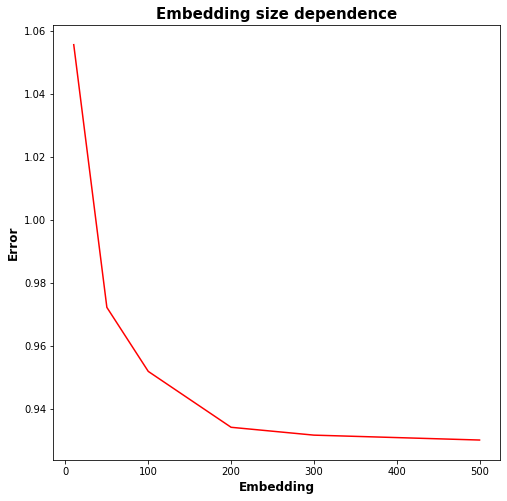

In [260]:
plt.figure(figsize=(8, 8))
plt.plot(results['Embedding'], results['Error'], color='red')
plt.title('Embedding size dependence', size=15, weight='bold')
plt.xlabel('Embedding', size=12, weight='bold')
plt.ylabel('Error', size=12, weight='bold')
plt.show()

**Вывод:** Размерность эмбеддинга улучшает точность до определенного момента, дальше может наступить переобучение

In [261]:
df_train, df_test = train_test_split(df, random_state=1412)
y_train = df_train['score']
y_test = df_test['score']
results_idf = pd.DataFrame({'Embedding': [], 'Error': []})
sizes = [10, 50, 100, 200, 300, 500, 1000]

frequency_positive = calc_idf(df['positive_splitted'])
frequency_negative = calc_idf(df['negative_splitted'])

for i, v_size in enumerate(tqdm(sizes)):    
    model_positive = Word2Vec(df['positive_splitted'], sg=1, epochs=5, vector_size=v_size, min_count=0)
    model_negative = Word2Vec(df['negative_splitted'], sg=1, epochs=5, vector_size=v_size, min_count=0)
    
    train_vec_positive = np.concatenate(df_train['positive_splitted'].apply(lambda x : vector_process(model_positive, x, frequency_positive)).values)
    train_vec_negative = np.concatenate(df_train['negative_splitted'].apply(lambda x : vector_process(model_negative, x, frequency_negative)).values)
    
    test_vec_positive = np.concatenate(df_test['positive_splitted'].apply(lambda x : vector_process(model_positive, x, frequency_positive)).values)
    test_vec_negative = np.concatenate(df_test['negative_splitted'].apply(lambda x : vector_process(model_negative, x, frequency_negative)).values)
    
    X_train = np.hstack((train_vec_negative, train_vec_positive))
    X_test = np.hstack((test_vec_negative, test_vec_positive))
    
    model = Ridge()
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    error = mean_absolute_error(y_test, pred)
    results_idf.loc[i] = [v_size, error]


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

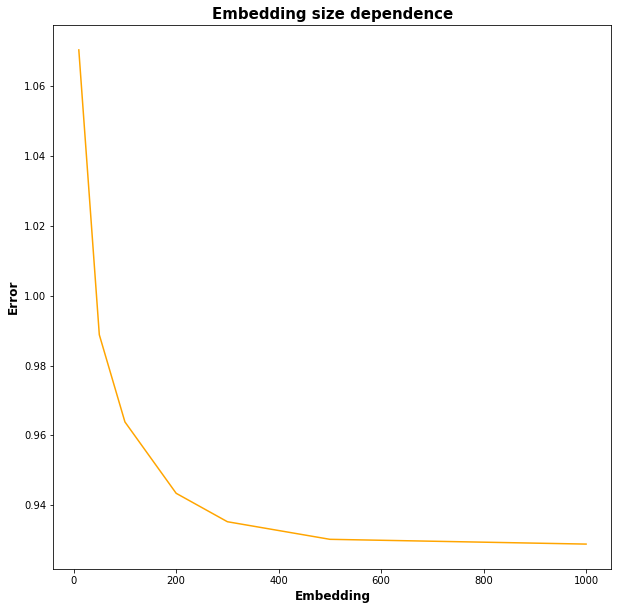

In [262]:
plt.figure(figsize=(10, 10))
plt.plot(results_idf['Embedding'], results_idf['Error'], color='orange')
plt.title('Embedding size dependence', size=15, weight='bold')
plt.xlabel('Embedding', size=12, weight='bold')
plt.ylabel('Error', size=12, weight='bold')
plt.show()

**Вывод:** Размерность эмбеддинга улучшает точность до определенного момента, дальше может наступить переобучение.

Теперь попробуйте обучить логистическую или линейную регрессию на любых других эмбеддингах размерности 300 и сравните качество с Word2Vec.

In [69]:
model_positive = fasttext.FastText(df['positive_splitted'], sg=1, epochs=10, vector_size=300, min_count=0)
model_negative = fasttext.FastText(df['negative_splitted'], sg=1, epochs=10, vector_size=300, min_count=0)
model_summary = fasttext.FastText(df['summary_splitted'], sg=1, epochs=10, vector_size=300, min_count=0)


In [70]:
model_positive.wv.unit_normalize_all()
model_negative.wv.unit_normalize_all()
model_summary.wv.unit_normalize_all()

In [71]:
train_vec_positive = np.concatenate(df_train['positive_splitted'].progress_apply(lambda x : vector_process(model_positive, x)).values)
train_vec_negative = np.concatenate(df_train['negative_splitted'].progress_apply(lambda x : vector_process(model_negative, x)).values)
train_vec_summary = np.concatenate(df_train['summary_splitted'].progress_apply(lambda x : vector_process(model_summary, x)).values)

test_vec_positive = np.concatenate(df_test['positive_splitted'].progress_apply(lambda x : vector_process(model_positive, x)).values)
test_vec_negative = np.concatenate(df_test['negative_splitted'].progress_apply(lambda x : vector_process(model_negative, x)).values)
test_vec_summary = np.concatenate(df_test['summary_splitted'].progress_apply(lambda x : vector_process(model_summary, x)).values)



  0%|          | 0/75000 [00:01<?, ?it/s]

  0%|          | 0/75000 [00:00<?, ?it/s]

  0%|          | 0/75000 [00:00<?, ?it/s]

  0%|          | 0/25000 [00:00<?, ?it/s]

  0%|          | 0/25000 [00:00<?, ?it/s]

  0%|          | 0/25000 [00:00<?, ?it/s]

In [72]:
X_train = np.hstack((train_vec_negative, train_vec_positive, train_vec_summary))
y_train = df_train['score']

X_test = np.hstack((test_vec_negative, test_vec_positive, test_vec_summary))
y_test = df_test['score']

In [73]:
model = Ridge()
model.fit(X_train, y_train)
pred = model.predict(X_test)
print('MAE: %.4f' % mean_absolute_error(y_test, pred))

MAE: 0.8727


**Вывод:** Качество осталось таким же

Предскажите вашей лучшей моделью из этого задания тестовые данные из [соревнования](https://www.kaggle.com/t/3e8fa6cec6d048bf8e93fb72e441d88c) и сделайте сабмит. Какой у вас получился скор? Прикрепите скриншот из кэггла.

In [74]:
## Сабмит был сделан моделью word2vec выше

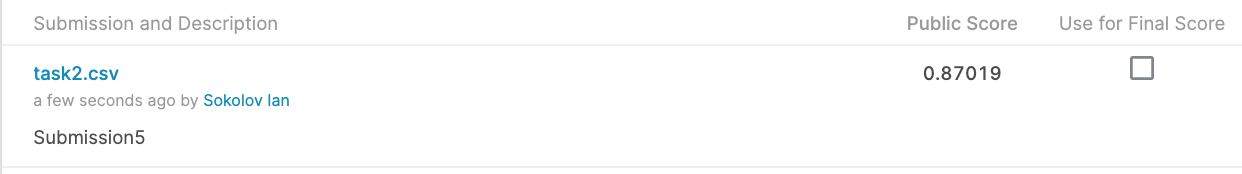

In [75]:
Image.open('task2.png')

### Часть 3. 4 балла

Теперь давайте воспользуемся более продвинутыми методами обработки текстовых данных, которые мы проходили в нашем курсе. Обучите RNN/Transformer для предсказания пользовательской оценки.

Если будете обучать RNN, попробуйте ограничить максимальную длину предложения. Некоторые отзывы могут быть слишком длинные относительно остальных.

Чтобы пользоваться DataLoader, все его элементы должны быть одинаковой размерности. Для этого вы можете добавить нулевой паддинг ко всем предложениям (см пример pad_sequence)

In [555]:
import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.nn.utils.rnn import pad_sequence
from pytorch_transformers import RobertaTokenizer, RobertaForSequenceClassification
from pytorch_transformers import RobertaConfig
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [439]:
WORDS = set()
for sent in list(df['positive_splitted']):
    for w in sent:
        WORDS.add(w)
        
for sent in list(df['negative_splitted']):
    for w in sent:
        WORDS.add(w)

In [440]:
int2word = dict(enumerate(tuple(WORDS)))
word2int = {w: ii for ii, w in int2word.items()}

In [442]:
MAX_LEN = max(max(df['positive'].apply(len)), max(df['negative'].apply(len)))
MAX_LEN

1963

In [466]:
train_pos_pad = pad_sequence([torch.as_tensor([word2int[w] for w in seq][:MAX_LEN]) for seq in df_train['positive_splitted']], 
                           batch_first=True)

In [468]:
class ReviewsDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        ## TODO
        self._tokens, self.targets  = df[0], df[1]

    def __len__(self):
        ## TODO
        return len(self._tokens)
    
    def __getitem__(self, idx: int):
        ## TODO
        return self._tokens[idx], torch.as_tensor(self.targets[idx])

In [469]:
train_dataset = ReviewsDataset((df_train['positive_splitted'], np.array(df_train['score'])))
test_dataset = ReviewsDataset((df_test['positive_splitted'], np.array(df_test['score'])))




In [470]:
BATCH_SIZE = 1

train_dataset = ReviewsDataset((train_reviews, np.array(df_train['score'])))
test_dataset = ReviewsDataset((test_reviews, np.array(df_test['score'])))

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [ ]:
NUM_EPOCHS = 1

for n in range(NUM_EPOCHS):
    model.train()
    ## TODO

Воспользуемся библиотекой simpletransformers

In [ ]:
## взято отсюда https://pypi.org/project/simpletransformers/0.48.3/

In [269]:
df_train['text'] = df_train['summary']
df_train['score'] = df_train['score']

df_test['text'] = df_test['summary']
df_test['score'] = df_test['score']

In [272]:
train_df = df_train[['summary', 'score']]
eval_df = df_test[['summary', 'score']]


train_args={
    'reprocess_input_data': True,
    'overwrite_output_dir': True,
    'num_train_epochs': 3,
    'regression': True,
    'train_eval_size':32
}

model = ClassificationModel('roberta', 'roberta-base', num_labels=1, use_cuda=True, cuda_device=0, args=train_args)

model.train_model(train_df, eval_df=eval_df)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

  0%|          | 0/75000 [00:00<?, ?it/s]

Process ForkPoolWorker-30:
Traceback (most recent call last):
  File "/Users/yasha_ten/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/yasha_ten/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/yasha_ten/anaconda3/lib/python3.7/multiprocessing/pool.py", line 135, in worker
    completed += 1
KeyboardInterrupt
Process ForkPoolWorker-31:
Traceback (most recent call last):
  File "/Users/yasha_ten/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/yasha_ten/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/yasha_ten/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/Users/yasha_ten/anaconda3/lib/python3.7/multiprocessing/queues.py", line 354, in get
    return _ForkingPickl

KeyboardInterrupt: 

In [273]:
result, model_outputs, wrong_predictions = model.eval_model(eval_df)

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/25000 [00:00<?, ?it/s]

Process ForkPoolWorker-35:
Traceback (most recent call last):
  File "/Users/yasha_ten/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/yasha_ten/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)


KeyboardInterrupt: 

In [267]:
# !rm -r outputs

### Контест (до 3 баллов)

По итогам всех ваших экспериментов выберите модель, которую считаете лучшей. Сделайте сабмит в контест. В зависимости от вашего скора на публичном лидерборде, мы начислим вам баллы:

 - <0.76 - 3 балла
 - [0.76; 0.78) - 2 балла
 - [0.78; 0.8) - 1 балл


Наилучшие результаты в ходе экспериментов показывала логистическая регрессия, решающая задачу классификации. С помощью метода **predict_proba** удалось использовать ее для решения поставленной нами задачи регрессии.

In [251]:
tfidf = TfidfVectorizer()
X_positive = tfidf.fit_transform(df['positive'])
X_positive_test = tfidf.transform(test['positive'])

X_negative = tfidf.fit_transform(df['negative'])
X_negative_test = tfidf.transform(test['negative'])

X_summary = tfidf.fit_transform(df['summary'])
X_summary_test = tfidf.transform(test['summary'])

X_train = hstack((X_positive, X_negative, X_summary))
y_train = df['score']

X_test = hstack((X_positive_test, X_negative_test, X_summary_test))


model = LogisticRegression(n_jobs=-1, C=4)
model.fit(X_train, (y_train * 10).astype(int))

pred = (model.predict_proba(X_train) * model.classes_).sum(axis=1) / 10

print(f'Train MAE: {mean_absolute_error(y_train, pred):.4f}')


Train MAE: 0.6975


In [252]:
pred = (model.predict_proba(X_test) * model.classes_).sum(axis=1) / 10

In [253]:
pd.DataFrame({'review_id': test['review_id'], 'score': pred}).to_csv('ans.csv', index=False)

In [254]:
name = "Submission{0}".format(k)
!kaggle competitions submit -c intro-to-dl-hw03 -f ans.csv -m $name
k += 1

100%|█████████████████████████████████████████| 994k/994k [00:02<00:00, 461kB/s]
Successfully submitted to Intro to deep learning 2021, homework 3

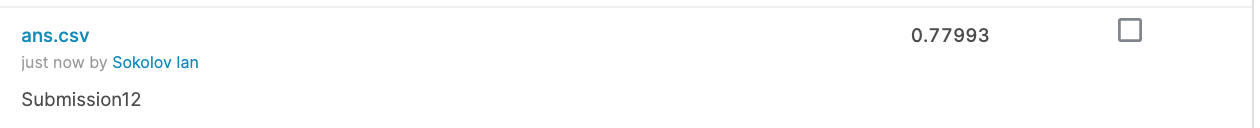

In [229]:
Image.open('task4.png')